# MNIST Dataset Introduction and Visualization

This notebook provides an introduction to the MNIST dataset and demonstrates various visualization techniques.

## Dependencies

Import required libraries and modules.

In [1]:
import sys
import os
from pathlib import Path


# Add project root to Python path
# Get current notebook path
notebook_path = Path.cwd()
# Go up one level to reach project root
project_root = notebook_path.parent
sys.path.insert(0, str(project_root))

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.decomposition import PCA
from src.utils.mnist_visualization import visualize_mnist_image
from sklearn.pipeline import FunctionTransformer, Pipeline
from sklearn.model_selection import train_test_split
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier

# Import PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

## Parameters
We will define paramters for this notebook, such as the proportion of the dataset used for training and testing, to speed up generation and testing.

In [2]:
# Define parameters
RANDOM_SEED = 42
SAMPLES_PER_LABEL = 1000
# Number of folds for cross-validation
CV_K_FOLD = 4
# Neural network training parameters
TRAIN_VALIDATION_SPLIT = 0.2
NUM_EPOCHS = 50  # Maximum number of epochs for training
PATIENCE = 5  # Number of epochs to wait for improvement before early stopping

## Loading MNIST Dataset

Before loading the dataset, you need to download it first by running the `data/download_mnist.py` script. This only needs to be done once. The data files are not included in version control as it's a good practice to separate data from code versioning.

The MNIST dataset is a large collection of handwritten digits that is commonly used for training various image processing systems. The database contains:
- 60,000 training images
- 10,000 testing images
- Each image is a 28x28 grayscale image of a single digit (0-9)
- Each pixel has a value between 0 (white) and 255 (black)

After downloading, the dataset will be available in CSV format in the `data` directory, ready to be loaded.

The script will prepare the data into two csv files:
- `train.csv`: contains the training images and their labels
- `test.csv`: contains the testing images and their labels

In [3]:
# Load training data
train_data = pd.read_csv(os.path.join(project_root, "data", "train.csv"))
X_train = train_data.iloc[:, 1:].values  # All columns except the first (labels)
y_train = train_data.iloc[:, 0].values  # First column (labels)

test_data = pd.read_csv(os.path.join(project_root, "data", "test.csv"))
X_test = test_data.iloc[:, 1:].values  # All columns except the first (labels)
y_test = test_data.iloc[:, 0].values  # First column (labels)
print(f"Dataset shape: {X_train.shape}")
print(f"Number of classes: {len(np.unique(y_train))}")

Dataset shape: (60000, 784)
Number of classes: 10


## Data Visualization

Data visualization is the first step in any data science project. It helps us understand the data, identify patterns, and detect potential issues. Let's start by exploring our MNIST dataset through different visualization techniques.

### Sample Images Visualization

Let's visualize one example for each digit class to get a sense of what our data looks like.

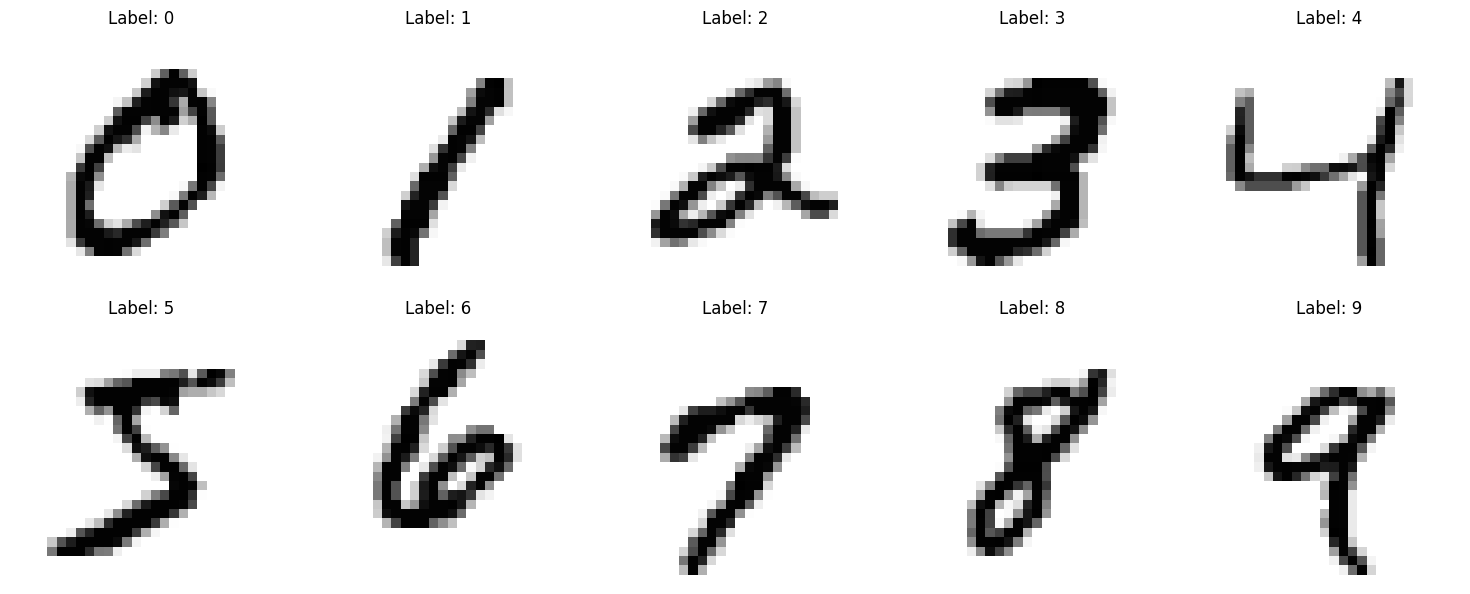

In [4]:
# Create a figure with subplots
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.ravel()

# Get one example for each digit (0-9)
for digit in range(10):
    # Find the first occurrence of this digit
    idx = np.where(y_train == digit)[0][0]
    visualize_mnist_image(X_train[idx], digit, ax=axes[digit])

plt.tight_layout()
plt.show()

### Class Distribution

Let's examine the distribution of classes in the dataset. This analysis is crucial for several reasons:
- To verify if the dataset is balanced across all digits (0-9)
- To identify any potential class imbalance that could bias our model training
- To ensure we have enough examples of each digit for effective learning
- To help determine if we need to apply any class balancing techniques

**Note: Deep learning models are indeed sensitive to class imbalance. However, traditional machine learning models may be more robust — it depends on the specific model and how it's implemented.**

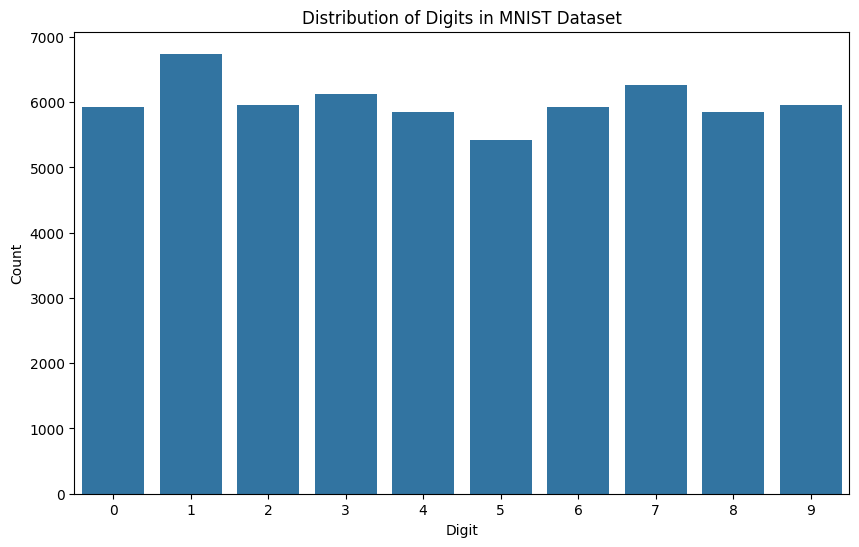

In [5]:
# Count occurrences of each digit
unique, counts = np.unique(y_train, return_counts=True)

# Create bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x=unique, y=counts)
plt.title("Distribution of Digits in MNIST Dataset")
plt.xlabel("Digit")
plt.ylabel("Count")
plt.show()

The classes are relatively well balanced, and the number of samples per class is sufficient for effective learning (>> 50).
### Pixel Value Distribution with PCA

Principal Component Analysis (PCA) is a dimensionality reduction technique that helps visualize high-dimensional data in a lower-dimensional space
while preserving as much variance as possible. For more details, see [Wikipedia](https://en.wikipedia.org/wiki/Principal_component_analysis).

Here, we use PCA to project our 784-dimensional data (28x28 pixels) onto a 2D plane. This visualization can give us insights into the complexity
of our classification task:
- If digits form well-separated clusters, the classification task should be relatively straightforward
- If digits overlap significantly, the task may be more challenging and require more sophisticated models

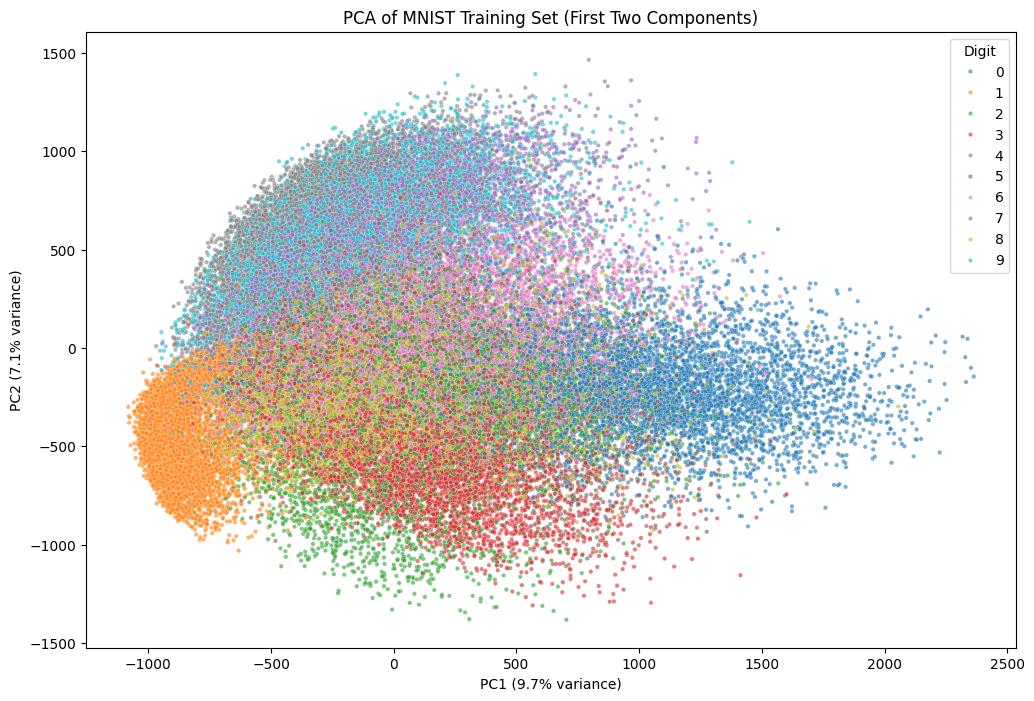

In [6]:
# Perform PCA and plot
plt.figure(figsize=(12, 8))
pca = PCA(n_components=2)
X_pca = pca.fit_transform(train_data.drop("label", axis=1))
df_pca = pd.DataFrame(X_pca, columns=["PC1", "PC2"])
df_pca["label"] = train_data["label"]

# Plot PCA results with a categorical color palette
sns.scatterplot(
    data=df_pca,
    x="PC1",
    y="PC2",
    hue="label",
    palette="tab10",  # Palette with good contrast for categorical data
    alpha=0.6,
    s=10,
)
plt.title("PCA of MNIST Training Set (First Two Components)")
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)")
plt.legend(title="Digit")

# Show all plots
plt.show()

We can see that :
- The first two axis of the PCA capture 17% of the variance of the data. It is not a lot, but it is still better than nothing.
- except for the digit 1, the other digits are quite blended in the same area, which can lead to a not trivial classification task.

## Classification Task

In this section, we will explore different machine learning approaches to solve the MNIST digit classification problem. We will implement and compare three different models:
- Random Forest Classifier
- PLS (Partial Least Squares) Classifier
- Simple Perceptron

Each model has its own strengths and characteristics that make it suitable for different aspects of the classification task. We will analyze their performance using standardized metrics to ensure a fair comparison.

### Metrics & Learning

When evaluating classification models, it's crucial to use appropriate metrics that provide a comprehensive view of the model's performance. Different metrics capture different aspects of the model's behavior:

- **Accuracy**: Overall proportion of correctly classified samples
- **Balanced Accuracy**: Accuracy adjusted for class imbalance
- **Confusion Matrix**: Detailed breakdown of correct and incorrect predictions per class
- **Classification Report**: Precision, recall, and F1-score for each class

We will use the metrics module from our project to ensure consistent evaluation across all models.

In [7]:
from src.metrics import (
    print_classification_metrics,
    plot_classification_metrics,
    ClassificationMetrics,
    plot_classification_metrics_sequence,
)

# These functions will help us:
# - print_classification_metrics: Display standard classification metrics
# - plot_classification_metrics: Visualize predictions and actual values
# - ClassificationMetrics: Store training metrics for each epoch
# - plot_classification_metrics_sequence: Visualize training progress over epochs (for deep learning models)

### Model Validation Strategy

The metrics are used to effectively evaluate our models and prevent overfitting. We will use two validation approaches adapted to different model types.

For Machine Learning algorithms, we will use k-fold [cross-validation](https://en.wikipedia.org/wiki/Cross-validation_(statistics)), which enables:
- More robust performance estimation
- Full utilization of available data for both training and validation
- Reduced variance in results

For the Deep Learning Models (like theSimple Perceptron), we will use a traditional train/validation split because:
- It allows real-time learning monitoring
- It facilitates early stopping to prevent overfitting
- It is better suited for models requiring iterative learning

While these approaches differ, they share the same goal: ensuring our models generalize well to new data, by limiting the risk of overfitting and by optimizing the hyperparameters.

### Preprocessing
We will preprocess the data for two main reasons:
- To balance the classes
- To ease the learning process by reducing the size of the dataset

In [8]:
# Shuffle training data while keeping label correspondence
indices = np.arange(len(y_train))
np.random.seed(RANDOM_SEED)
np.random.shuffle(indices)
X_train_shuffled = X_train[indices]
y_train_shuffled = y_train[indices]

# Initialize lists to store selected samples
X_train_preprocessed = []
y_train_preprocessed = []

# Keep track of samples per label
samples_count = {i: 0 for i in range(10)}

# Select first SAMPLES_PER_LABEL samples for each label
for X_sample, y_label in zip(X_train_shuffled, y_train_shuffled):
    if samples_count[y_label] < SAMPLES_PER_LABEL:
        X_train_preprocessed.append(X_sample)
        y_train_preprocessed.append(y_label)
        samples_count[y_label] += 1

    # Check if we have enough samples for all labels
    if all(count >= SAMPLES_PER_LABEL for count in samples_count.values()):
        break

# Convert lists to numpy arrays
X_train_preprocessed = np.array(X_train_preprocessed)
y_train_preprocessed = np.array(y_train_preprocessed)

print(f"Preprocessed dataset shape: {X_train_preprocessed.shape}")

Preprocessed dataset shape: (10000, 784)


## Random Forest Classifier

The Random Forest Classifier is a powerful ensemble learning method that builds multiple decision trees and combines their predictions to improve accuracy and reduce overfitting.

Fitting 4 folds for each of 48 candidates, totalling 192 fits


Best parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best cross-validation score: 0.9476



Test Set Performance:

Metrics for test set:
Accuracy: 0.9539
Balanced Accuracy: 0.9536

Confusion Matrix:
[[ 967    0    0    0    0    3    5    1    3    1]
 [   0 1120    3    3    1    1    4    1    2    0]
 [   9    0  972    9   12    0    8   13    8    1]
 [   2    0   13  946    0   20    0   13   11    5]
 [   1    0    2    0  937    1    9    0    7   25]
 [   4    1    2   17    4  846    8    2    5    3]
 [  12    3    1    0    5    4  930    0    3    0]
 [   3    6   25    2    3    0    0  964    3   22]
 [   4    0    7   11    6    7    8    6  908   17]
 [   5    6    2   13    9   10    2    4    9  949]]

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.99      0.97       980
           1       0.99      0.99      0.99      1135
           2       0.95      0.94      0.94      1032
           3       0.95      0.94      0.94      1010
           4       0.96      0.95      0.96       982
           5

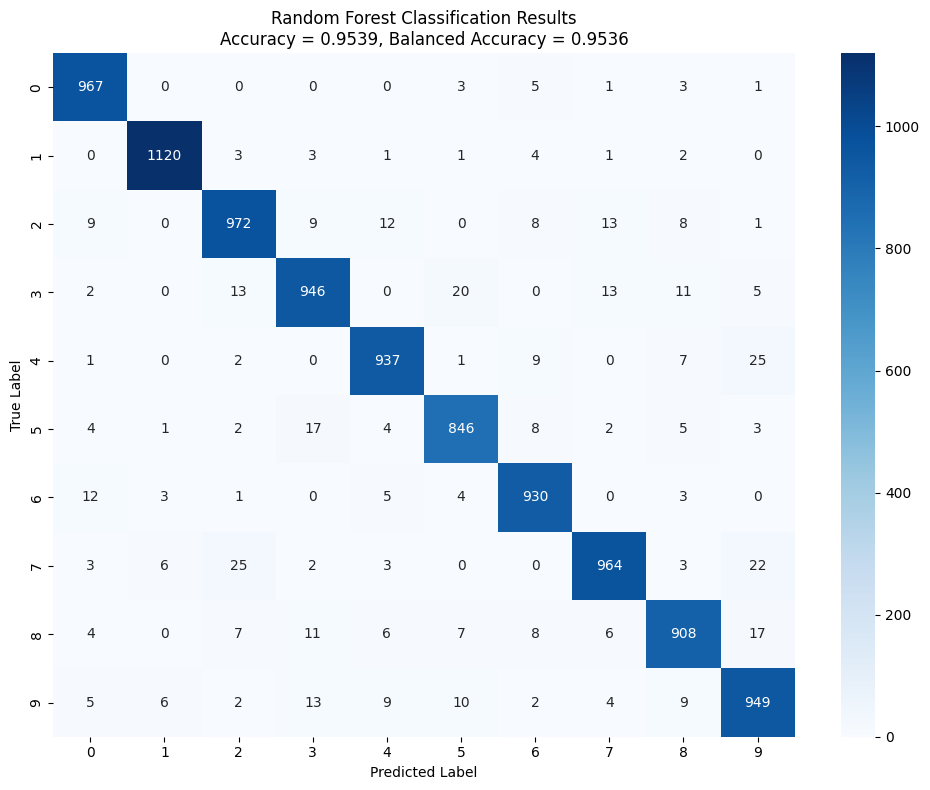

In [9]:
# Define parameter grid for Random Forest
param_grid = {
    "n_estimators": [100, 200],
    "max_depth": [10, 20, None],
    "min_samples_split": [2, 5],
    "min_samples_leaf": [1, 2, 3, 5],
}

# Initialize Random Forest model
rf_model = RandomForestClassifier(random_state=42)

# Perform GridSearchCV with 4-fold cross-validation
grid_search = GridSearchCV(
    estimator=rf_model,
    param_grid=param_grid,
    cv=CV_K_FOLD,
    n_jobs=-1,
    scoring="accuracy",
    verbose=1,
)

# Fit the model
grid_search.fit(X_train_preprocessed, y_train_preprocessed)

# Print best parameters and score
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)

# Get best model
best_rf = grid_search.best_estimator_

# Make predictions on test set
y_pred = best_rf.predict(X_test)

# Print and plot classification metrics
print("\nTest Set Performance:")
print_classification_metrics(y_test, y_pred)
plot_classification_metrics(y_test, y_pred, "Random Forest Classification Results")

### Results Analysis


The best model has an accuracy of > 95% on the test set, as well as a balanced accuracy of > 95%.
The confusion matrix is also quite good, with a low number of false positives and false negatives.
The precision, recall and F1-score are also quite good for each class.

## Partial Least Squares (PLS) Analysis

PLS is a dimensionality reduction and regression technique that finds the directions of maximum covariance between X and Y.
While it's primarily used for regression, we can adapt it for classification by using one-hot encoded target variables.

### Pretreatment
To use the PLS model, we need to convert the labels into a regression target, which means we will switch from a classification task to a regression task. To do so, we use a one-hot encoding of the labels, with as much dimensions as there are classes in the dataset and a single 1 value for the correct class.

In [10]:
# One-hot encode labels
encoder = OneHotEncoder(sparse_output=False)
y_train_encoded = encoder.fit_transform(y_train_preprocessed.reshape(-1, 1))

# Create class mapping
feature_names = encoder.get_feature_names_out(["digit"])
class_mapping = {i: int(name.split("_")[1]) for i, name in enumerate(feature_names)}

### Setting up the PLS model

Starting grid search for PLS regression...
Fitting 4 folds for each of 16 candidates, totalling 64 fits



Grid Search Results:
Best parameters: {'n_components': 17}
Best cross-validation R2 score: 0.5098


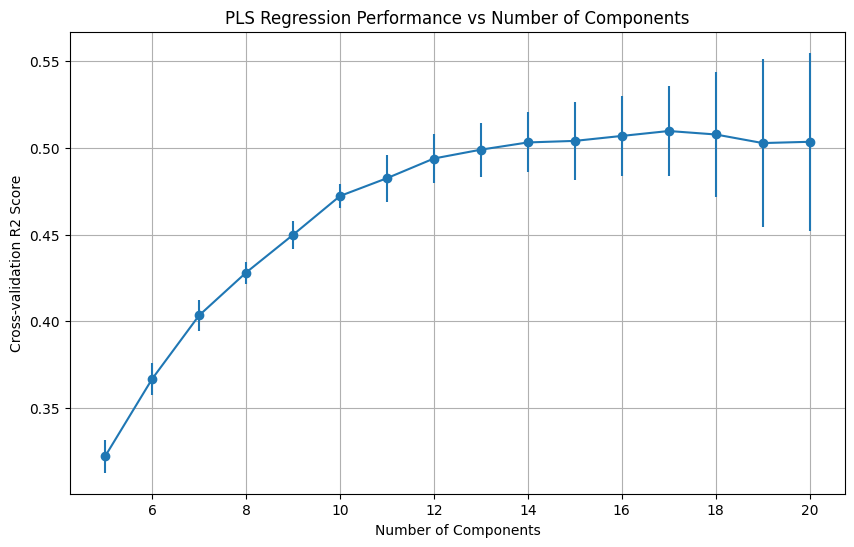

In [11]:
# Define parameter grid for cross-validation
param_grid = {"n_components": list(range(5, 21))}

# Initialize PLS model
pls = PLSRegression()

# Perform GridSearchCV with R2 scoring
grid_search = GridSearchCV(
    estimator=pls,
    param_grid=param_grid,
    cv=CV_K_FOLD,
    scoring="r2",
    n_jobs=-1,
    verbose=1,
)

print("Starting grid search for PLS regression...")
grid_search.fit(X_train_preprocessed, y_train_encoded)

# Print results
print("\nGrid Search Results:")
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation R2 score: {grid_search.best_score_:.4f}")

# Plot cross-validation results
cv_results = pd.DataFrame(grid_search.cv_results_)
results_summary = cv_results[
    ["param_n_components", "mean_test_score", "std_test_score"]
]
results_summary = results_summary.sort_values("param_n_components")

plt.figure(figsize=(10, 6))
plt.errorbar(
    results_summary["param_n_components"],
    results_summary["mean_test_score"],
    yerr=results_summary["std_test_score"],
    fmt="o-",
)
plt.xlabel("Number of Components")
plt.ylabel("Cross-validation R2 Score")
plt.title("PLS Regression Performance vs Number of Components")
plt.grid(True)
plt.show()

# Use best model for predictions
best_pls = grid_search.best_estimator_

### Predictions & Conclusion


Classification Metrics on Test Set:

Metrics for test set:
Accuracy: 0.8544
Balanced Accuracy: 0.8525

Confusion Matrix:
[[ 938    0    1    3    1   13   18    1    5    0]
 [   0 1100    3    2    1    1    4    1   23    0]
 [  22   59  785   28   23    0   36   26   48    5]
 [   5   23   24  862    3   30    8   27   19    9]
 [   2   27    4    0  883    7   12    2   10   35]
 [  11   16    6   59   29  674   27   13   39   18]
 [  23   14   10    0   19   18  873    0    1    0]
 [   5   50   16    8   21    1    1  873    5   48]
 [  12   50    7   29   25   48   15   19  754   15]
 [  18   13    4   18   77    5    0   67    5  802]]

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.96      0.93       980
           1       0.81      0.97      0.88      1135
           2       0.91      0.76      0.83      1032
           3       0.85      0.85      0.85      1010
           4       0.82      0.90      0.86       98

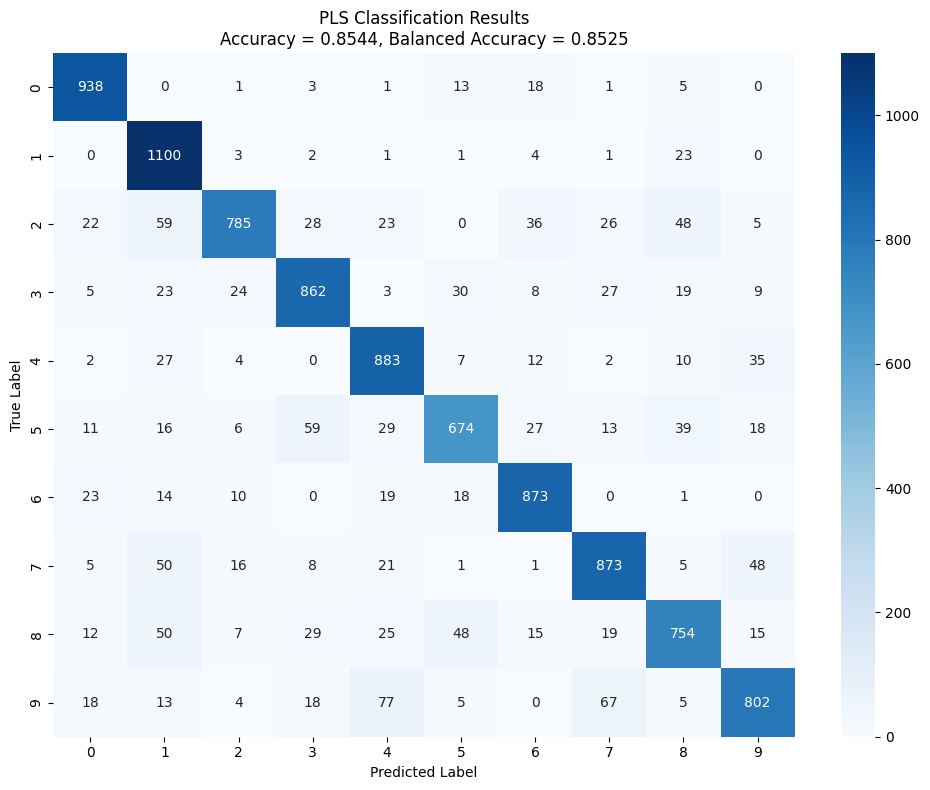

In [12]:
# Make predictions on test set
y_test_pred_raw = best_pls.predict(X_test)
y_test_pred_classes = np.array(
    [class_mapping[i] for i in np.argmax(y_test_pred_raw, axis=1)]
)

# Print and plot classification metrics
print("\nClassification Metrics on Test Set:")
y_test_array = np.array(y_test)
y_test_pred_classes_array = np.array(y_test_pred_classes)
print_classification_metrics(y_test_array, y_test_pred_classes_array)
plot_classification_metrics(
    y_test_array, y_test_pred_classes_array, "PLS Classification Results"
)

### Results Analysis

The PLS model performs a bit lower than the Random Forest model, with an accuracy and a balanced accuracy a bit above 85%.
It is not bad in itself, but produce three times more error than the Random Forest model.

## Perceptron

The Perceptron is the simplest deep learning model. It consists of a single layer of neurons that takes as input
the image pixels (784 values) and outputs 10 values (one for each class).

### Model Implementation

In [13]:
class SimplePerceptron(nn.Module):
    """Simple Perceptron model for MNIST classification.

    Args:
        input_size: Number of input features (784 for MNIST)
        num_classes: Number of output classes (10 for MNIST)
    """

    def __init__(self, input_size: int, num_classes: int) -> None:
        super().__init__()
        self.linear = nn.Linear(input_size, num_classes)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Forward pass of the model.

        Args:
            x: Input tensor of shape (batch_size, input_size)

        Returns:
            Output tensor of shape (batch_size, num_classes)
        """
        return self.linear(x)

### Data Preparation

We need to:
1. Convert our NumPy data to PyTorch tensors and normalize them
2. Split training data into train and validation sets
3. Create data loaders for each set

In [14]:
# Convert preprocessed data to PyTorch tensors and normalize
X_preprocessed_tensor = torch.FloatTensor(X_train_preprocessed) / 255.0
y_preprocessed_tensor = torch.LongTensor(y_train_preprocessed)

# Split preprocessed data into train and validation sets
X_train_tensor, X_val_tensor, y_train_tensor, y_val_tensor = train_test_split(
    X_preprocessed_tensor,
    y_preprocessed_tensor,
    test_size=TRAIN_VALIDATION_SPLIT,
    random_state=RANDOM_SEED,
    stratify=y_preprocessed_tensor,
)

# Convert test data to tensors (will only be used for final evaluation)
X_test_tensor = torch.FloatTensor(X_test) / 255.0
y_test_tensor = torch.LongTensor(y_test)

# Create data loaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

### Model, criterion and optimizer
We use a CrossEntropyLoss as criterion to compute the loss between the predicted and the true labels. The same logic is applied form the PLS model, where we need to convert the classification to a regression one.

In [15]:
# Initialize model, loss function and optimizer
model = SimplePerceptron(input_size=784, num_classes=10)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# %%[markdown]
# ### Training loop
# We will use early stopping based on validation loss to prevent overfitting.

In [16]:
# Training parameters
best_val_loss = float("inf")
patience_counter = 0
metrics = []

# Training loop
print("Starting training...")
for epoch in range(NUM_EPOCHS):
    # Training phase
    model.train()
    running_train_loss = 0.0

    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item()

    avg_train_loss = running_train_loss / len(train_loader)

    # Validation phase
    model.eval()
    running_val_loss = 0.0
    val_preds = []
    val_labels = []

    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            val_preds.extend(predicted.numpy())
            val_labels.extend(labels.numpy())

    avg_val_loss = running_val_loss / len(val_loader)
    val_accuracy = np.mean(np.array(val_preds) == np.array(val_labels))

    # Store metrics
    metrics.append(
        {
            "epoch": epoch + 1,
            "train_loss": avg_train_loss,
            "val_loss": avg_val_loss,
            "val_accuracy": val_accuracy,
        }
    )

    # Print progress
    print(f"Epoch {epoch+1}/{NUM_EPOCHS}")
    print(f"Train Loss: {avg_train_loss:.4f}")
    print(f"Validation Loss: {avg_val_loss:.4f}")
    print(f"Validation Accuracy: {val_accuracy:.4f}")
    print("----------------------------------------")

    # Early stopping check
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
        # Save best model state
        best_model_state = model.state_dict()
    else:
        patience_counter += 1
        if patience_counter >= PATIENCE:
            print(f"Early stopping triggered after {epoch + 1} epochs")
            break

Starting training...
Epoch 1/50
Train Loss: 0.9485
Validation Loss: 0.5910
Validation Accuracy: 0.8545
----------------------------------------


Epoch 2/50
Train Loss: 0.4858
Validation Loss: 0.4998
Validation Accuracy: 0.8670
----------------------------------------
Epoch 3/50
Train Loss: 0.4181
Validation Loss: 0.4608
Validation Accuracy: 0.8770
----------------------------------------


Epoch 4/50
Train Loss: 0.3819
Validation Loss: 0.4371
Validation Accuracy: 0.8810
----------------------------------------
Epoch 5/50
Train Loss: 0.3585
Validation Loss: 0.4244
Validation Accuracy: 0.8840
----------------------------------------


Epoch 6/50
Train Loss: 0.3431
Validation Loss: 0.4127
Validation Accuracy: 0.8870
----------------------------------------
Epoch 7/50
Train Loss: 0.3295
Validation Loss: 0.4081
Validation Accuracy: 0.8875
----------------------------------------


Epoch 8/50
Train Loss: 0.3189
Validation Loss: 0.3988
Validation Accuracy: 0.8900
----------------------------------------
Epoch 9/50
Train Loss: 0.3118
Validation Loss: 0.3942
Validation Accuracy: 0.8930
----------------------------------------


Epoch 10/50
Train Loss: 0.3031
Validation Loss: 0.3887
Validation Accuracy: 0.8940
----------------------------------------


Epoch 11/50
Train Loss: 0.2965
Validation Loss: 0.3862
Validation Accuracy: 0.8945
----------------------------------------


Epoch 12/50
Train Loss: 0.2916
Validation Loss: 0.3833
Validation Accuracy: 0.8970
----------------------------------------


Epoch 13/50
Train Loss: 0.2860
Validation Loss: 0.3829
Validation Accuracy: 0.8965
----------------------------------------


Epoch 14/50
Train Loss: 0.2816
Validation Loss: 0.3789
Validation Accuracy: 0.8895
----------------------------------------


Epoch 15/50
Train Loss: 0.2772
Validation Loss: 0.3781
Validation Accuracy: 0.8965
----------------------------------------


Epoch 16/50
Train Loss: 0.2734
Validation Loss: 0.3761
Validation Accuracy: 0.8955
----------------------------------------


Epoch 17/50
Train Loss: 0.2698
Validation Loss: 0.3769
Validation Accuracy: 0.8950
----------------------------------------


Epoch 18/50
Train Loss: 0.2663
Validation Loss: 0.3749
Validation Accuracy: 0.8990
----------------------------------------


Epoch 19/50
Train Loss: 0.2630
Validation Loss: 0.3739
Validation Accuracy: 0.8980
----------------------------------------


Epoch 20/50
Train Loss: 0.2609
Validation Loss: 0.3707
Validation Accuracy: 0.9005
----------------------------------------


Epoch 21/50
Train Loss: 0.2579
Validation Loss: 0.3701
Validation Accuracy: 0.8990
----------------------------------------


Epoch 22/50
Train Loss: 0.2548
Validation Loss: 0.3737
Validation Accuracy: 0.8940
----------------------------------------


Epoch 23/50
Train Loss: 0.2524
Validation Loss: 0.3730
Validation Accuracy: 0.8995
----------------------------------------


Epoch 24/50
Train Loss: 0.2500
Validation Loss: 0.3683
Validation Accuracy: 0.8985
----------------------------------------


Epoch 25/50
Train Loss: 0.2476
Validation Loss: 0.3655
Validation Accuracy: 0.8950
----------------------------------------


Epoch 26/50
Train Loss: 0.2454
Validation Loss: 0.3671
Validation Accuracy: 0.8965
----------------------------------------


Epoch 27/50
Train Loss: 0.2434
Validation Loss: 0.3655
Validation Accuracy: 0.8975
----------------------------------------


Epoch 28/50
Train Loss: 0.2420
Validation Loss: 0.3660
Validation Accuracy: 0.8970
----------------------------------------


Epoch 29/50
Train Loss: 0.2396
Validation Loss: 0.3673
Validation Accuracy: 0.8965
----------------------------------------


Epoch 30/50
Train Loss: 0.2371
Validation Loss: 0.3646
Validation Accuracy: 0.8975
----------------------------------------


Epoch 31/50
Train Loss: 0.2361
Validation Loss: 0.3667
Validation Accuracy: 0.8965
----------------------------------------


Epoch 32/50
Train Loss: 0.2341
Validation Loss: 0.3661
Validation Accuracy: 0.8985
----------------------------------------


Epoch 33/50
Train Loss: 0.2322
Validation Loss: 0.3632
Validation Accuracy: 0.8970
----------------------------------------


Epoch 34/50
Train Loss: 0.2319
Validation Loss: 0.3624
Validation Accuracy: 0.8970
----------------------------------------


Epoch 35/50
Train Loss: 0.2302
Validation Loss: 0.3651
Validation Accuracy: 0.8990
----------------------------------------


Epoch 36/50
Train Loss: 0.2285
Validation Loss: 0.3664
Validation Accuracy: 0.8970
----------------------------------------


Epoch 37/50
Train Loss: 0.2260
Validation Loss: 0.3694
Validation Accuracy: 0.9000
----------------------------------------


Epoch 38/50
Train Loss: 0.2255
Validation Loss: 0.3657
Validation Accuracy: 0.8980
----------------------------------------


Epoch 39/50
Train Loss: 0.2243
Validation Loss: 0.3625
Validation Accuracy: 0.8980
----------------------------------------
Early stopping triggered after 39 epochs


We plot the training progress to see when the model is overfitting.

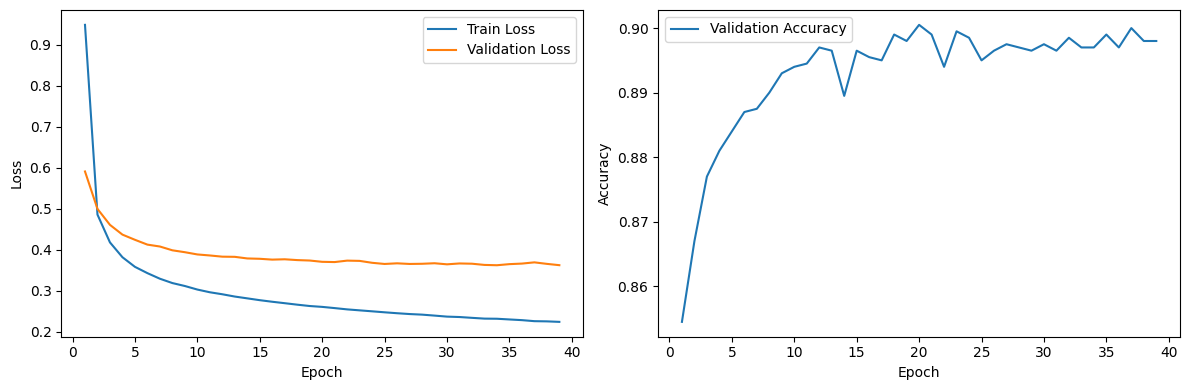

In [17]:
# Plot training progress
epochs = [m["epoch"] for m in metrics]
train_losses = [m["train_loss"] for m in metrics]
val_losses = [m["val_loss"] for m in metrics]
val_accuracies = [m["val_accuracy"] for m in metrics]

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label="Train Loss")
plt.plot(epochs, val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, val_accuracies, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.tight_layout()
plt.show()

### Final evaluation
We load the best model and evaluate it on the test set.

In [18]:
# Load best model for final evaluation
model.load_state_dict(best_model_state)

print("\nFinal Test Set Performance:")
model.eval()
test_preds = []
test_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        test_preds.extend(predicted.numpy())
        test_labels.extend(labels.numpy())


Final Test Set Performance:


### Results Analysis
We print the results and plot the confusion matrix.


Metrics for test set:
Accuracy: 0.9124
Balanced Accuracy: 0.9111

Confusion Matrix:
[[ 954    0    2    1    0    9   10    2    2    0]
 [   0 1111    2    3    0    4    4    1   10    0]
 [  14    8  916   15   11    1   12   11   37    7]
 [   4    1   18  897    1   39    4   16   20   10]
 [   2    4    7    2  898    0   17    2   11   39]
 [  12    4    6   45    5  757   18    8   29    8]
 [  15    3    5    2    9   12  909    1    2    0]
 [   3    8   22    6   10    2    0  938    3   36]
 [   8   10    7   16   11   32   16   15  850    9]
 [  15    4    1   10   38   11    0   25   11  894]]

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.97      0.95       980
           1       0.96      0.98      0.97      1135
           2       0.93      0.89      0.91      1032
           3       0.90      0.89      0.89      1010
           4       0.91      0.91      0.91       982
           5       0.87      0.85  

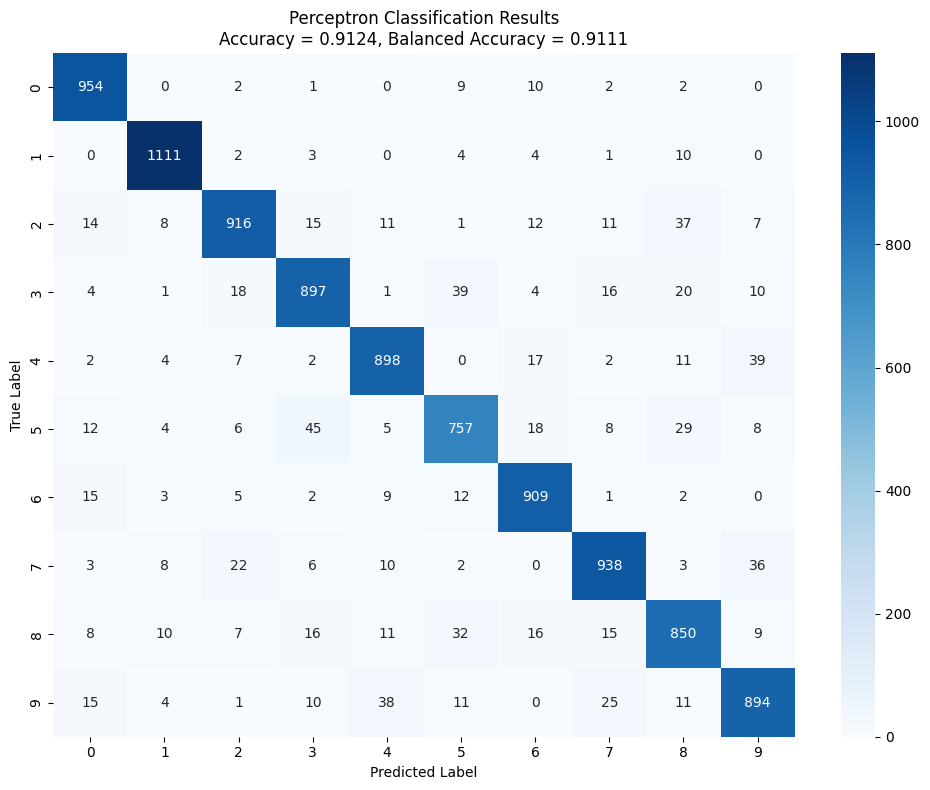

In [19]:
print_classification_metrics(np.array(test_labels), np.array(test_preds))
plot_classification_metrics(
    np.array(test_labels), np.array(test_preds), "Perceptron Classification Results"
)

The results are comparable to the Random Forest model, with an accuracy and a balanced accuracy a bit above 91%.